In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## PROBLEM STATEMENT

Welcome to our regular closed dataset based weekend hackathon. In this weekend hackathon, we are challenging all the machinehackers to predict the melanoma tumor size based on various attributes. Melanomas present in many different shapes, sizes, and colors. That’s why it’s tricky to provide a comprehensive set of warning signs. Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. 

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, there were 3.1 million people with active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. There are also high rates in Northern Europe and North America, while it is less common in Asia, Africa, and Latin America. In the United States melanoma occurs about 1.6 times more often in men than women.

 

## Data Description:

Train.csv - 9146 rows x 9 columns
Test.csv - 36584 rows x 8 columns
Sample Submission - Acceptable submission format
 

## Attributes Description:

mass_npea:  the mass of the area understudy for melanoma tumor
size_npear: the size of the area understudy for melanoma tumor
malign_ratio: ration of normal to malign surface understudy
damage_size: unrecoverable area of skin damaged by the tumor
exposed_area: total area exposed to the tumor
std_dev_malign: standard deviation of malign skin measurements
err_malign: error in malign skin measurements
malign_penalty: penalty applied due to measurement error in the lab
damage_ratio: the ratio of damage to total spread on the skin
tumor_size: size of melanoma_tumor

# Hypothesis Generation



Before starting with Hypothesis let us get some domain knownledge of Skin Cancer by answering few questions related to skin cancer.

* Melanoma Skin Cancer is the deadliest form of cancer. It originates in the pigment-producing melanocytes in the basal layer of the epidermis. Clinically, it can be identified through a skin biopsy.

* Melanoma Skin Cancer is life-threatening and can grow very quickly. It develops when unrepaired DNA damage to the skin cells triggers mutations that lead the skin cells to multiply rapidly and form malignant tumours.

* Melanoma Skin Cancer often resembles or may develop from moles. Brown or black skin lesions but can appear as pink, red, blue or white. These cancerous growths have irregular symmetry, edges that may be scalloped or notched and are larger in diameter (more than 7mm). There may be spread of pigment from the border of a spot into the surrounding skin. Melanoma skin cancer may be accompanied by both change in sensation (itchiness, pain) and surface of the mole (oozing. scaliness, bleeding).



In [ ]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('hXYd0WRhzN4',width=800, height=500)

### What are the causes of Skin Cancer?
More than 90% of the cases are caused by excessive exposure to ultraviolet radiations emitted by the sun. This excessive emission occurs due to the thinning of the ozone layer which of course acts as a filter to the harmful ultraviolet radiations. People with light skin colour, hazel or blue eyes, extra sensitive skin are exposed more towards the risk.

When ultraviolet radiations contribute mostly to this cause, other causes include smoking, having tobacco, sometimes genetic syndromes like moles that increase drastically, chronic wounds that are non-healing, Xrays, artificial methods of getting a tan like tanning beds, use of medicines that decrease immunity etc.

Smoking tobacco not only increases the chances of causing other types of cancer but also it contributes to an effective cause of skin cancer. Moles, abnormal growth marks since birth, birthmarks are not exactly cancerous but if at all there is any kind of growth in them, it is a cause to worry. Tanning beds are very common to get an artificial, cosmetic tan and as much as they are successful in providing tan, there are approximately 90% cases in which skin cancer occurs after this treatment.

Any wound that has been active for more than the stipulated time, blister-like red-pinkish mark or any rash that is growing every day, needs to be consulted.

It is said that use of sunscreens is an effective way of preventing skin cancer; however, the effectiveness cannot be measured. The changing lifestyle and more exposure to the harmful rays, all this drastically contributes to causing skin cancer.

Now lets create some Hypothesis using our dataset

* Do the mass and the size of area understudy for melanoma tumor results in larger tumor?
* How dangerous will be the results if there is high error in malign skin measurements?
* The ratio of damage to total spread on the skin, do create an impact?



In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import  RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [2]:
sample = pd.read_csv("/kaggle/input/melanomatumorsizepredicition/sample_submission.csv")
train = pd.read_csv("/kaggle/input/melanomatumorsizepredicition/Train.csv")
test = pd.read_csv("/kaggle/input/melanomatumorsizepredicition/Test.csv")

In [3]:
def class_distribution(df, target_col):
  '''
  Function to view distribution of target class
  '''
  class_dist = df[target_col].value_counts().to_dict()
  for i in class_dist.keys():
    percent = (class_dist[i]/train.shape[0])*100
    print(f'Number of records in class {i}: '+str(round(percent,2))+'% values:' +  str(class_dist[i]) )


def miss_data(df):
  '''
  Missing data details
  '''
  x = ['column_name','missing_data', 'missing_in_percentage']
  missing_data = pd.DataFrame(columns=x)
  columns = df.columns
  for col in columns:
      icolumn_name = col
      imissing_data = df[col].isnull().sum()
      imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100

      missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
  print(missing_data)

In [4]:
#Model Evaluation

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(RMSE, greater_is_better=False)

In [5]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')


Train contains 9146 samples and 10 variables

Test contains 36584 samples and 9 variables


In [6]:
train.head(3)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.9,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.7,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.2,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688


In [7]:
test.head(3)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,4946.44,914.06,0.18479,54.5566,6.628345e+05,67.0525,2301.76,22,41.9554
1,5613.85,1629.12,0.29019,51.5524,7.842271e+05,80.1986,3235.00,48,40.7410
2,12421.10,3062.41,0.24654,154.1560,1.763575e+06,186.8590,4684.63,63,29.4778


In [8]:
TARGET_COL = 'tumor_size'
features = [c for c in train.columns if c not in [ TARGET_COL]]

In [9]:
print(f'\nThe dataset contains {len(features)} features')


The dataset contains 9 features


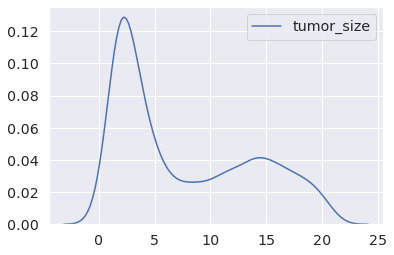

In [10]:
sns.set(font_scale=1.3)

sns.kdeplot(train['tumor_size'])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9146 entries, 0 to 9145
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mass_npea       9146 non-null   float64
 1   size_npear      9146 non-null   float64
 2   malign_ratio    9146 non-null   float64
 3   damage_size     9146 non-null   float64
 4   exposed_area    9146 non-null   float64
 5   std_dev_malign  9146 non-null   float64
 6   err_malign      9146 non-null   float64
 7   malign_penalty  9146 non-null   int64  
 8   damage_ratio    9146 non-null   float64
 9   tumor_size      9146 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 714.7 KB


In [12]:
cat_cols = []

In [13]:
num_cols =  [c for c in features if c not in cat_cols]

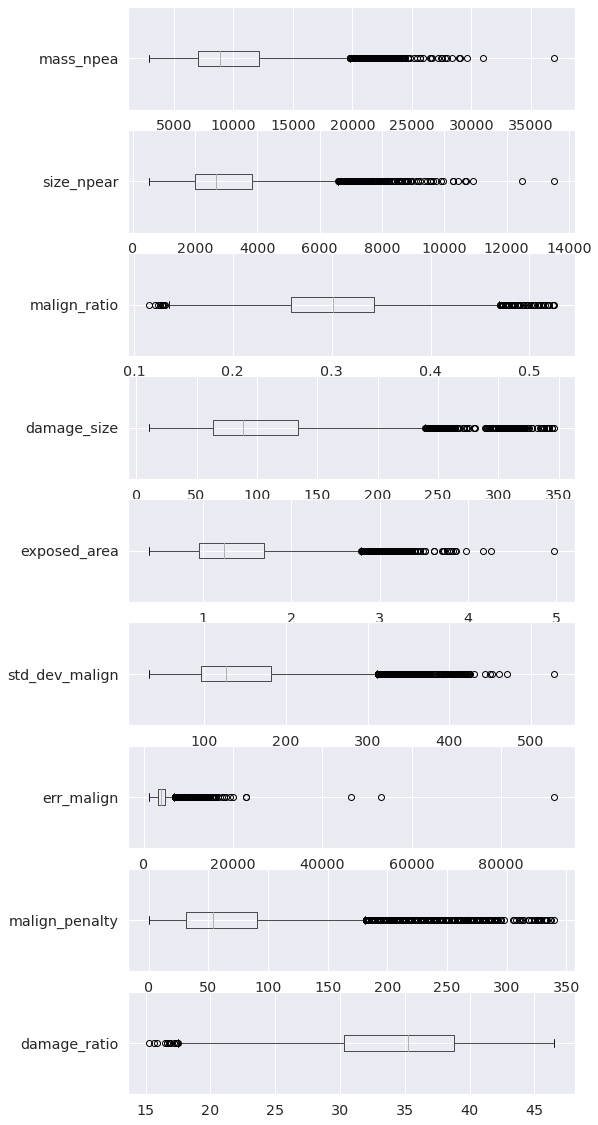

In [14]:
fig, axes = plt.subplots(9, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

In [15]:
miss_data(test)

      column_name missing_data  missing_in_percentage
0       mass_npea            0                    0.0
1      size_npear            0                    0.0
2    malign_ratio            0                    0.0
3     damage_size            0                    0.0
4    exposed_area            0                    0.0
5  std_dev_malign            0                    0.0
6      err_malign            0                    0.0
7  malign_penalty            0                    0.0
8    damage_ratio            0                    0.0


In [16]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
tumor_size,0,0.0
damage_ratio,0,0.0
malign_penalty,0,0.0
err_malign,0,0.0
std_dev_malign,0,0.0


EDA 

In [17]:
def nor(x):
  sk=x.skew()
  sq=(np.sqrt(x)).skew()
  lg=(np.log1p(x)).skew()
  return {"skew":sk,"sqrt":sq,"log":lg}

In [18]:
data=pd.concat([train,test],ignore_index=True)

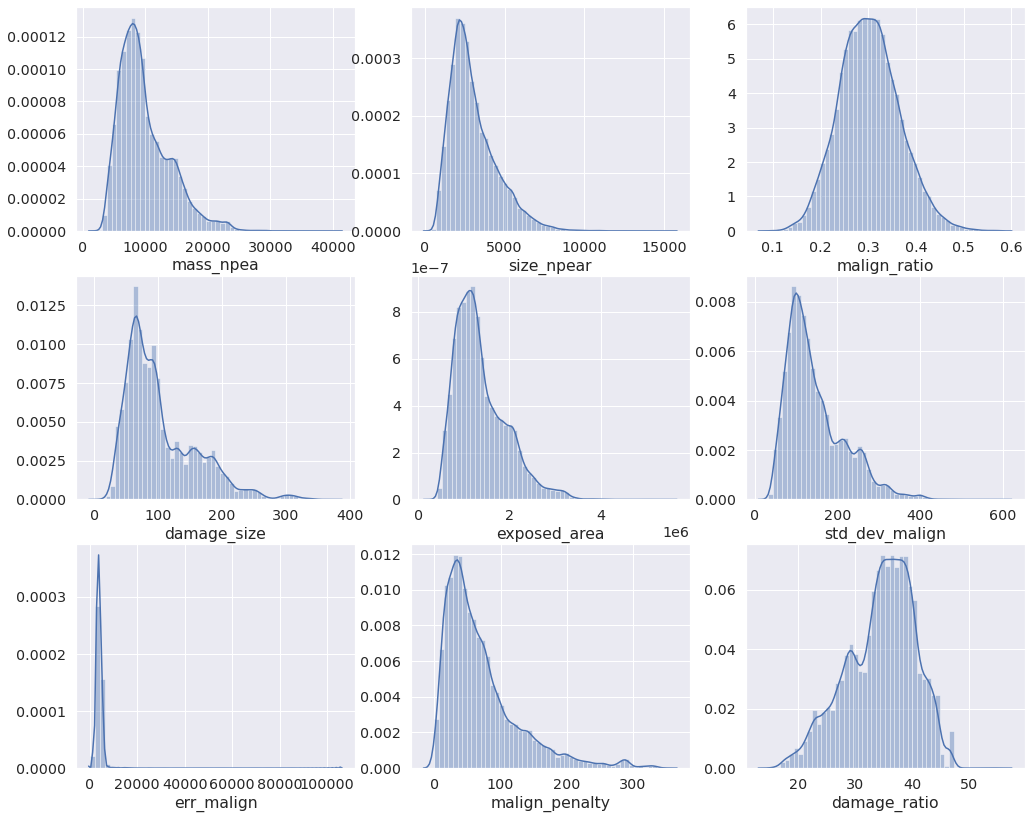

In [19]:
plt.figure(figsize=(17,14))
plt.subplot(3,3,1)
sns.distplot(data.mass_npea)
plt.subplot(3,3,2)
sns.distplot(data.size_npear)
plt.subplot(3,3,3)
sns.distplot(data.malign_ratio)
plt.subplot(3,3,4)
sns.distplot(data.damage_size)
plt.subplot(3,3,5)
sns.distplot(data.exposed_area)
plt.subplot(3,3,6)
sns.distplot(data.std_dev_malign)
plt.subplot(3,3,7)
sns.distplot(data.err_malign)
plt.subplot(3,3,8)
sns.distplot(data.malign_penalty)
plt.subplot(3,3,9)
sns.distplot(data.damage_ratio)

In [20]:
data.columns

Index(['mass_npea', 'size_npear', 'malign_ratio', 'damage_size',
       'exposed_area', 'std_dev_malign', 'err_malign', 'malign_penalty',
       'damage_ratio', 'tumor_size'],
      dtype='object')

In [21]:
from IPython.display import display
display(print("1. mass_npea"))
display(nor(data.mass_npea))
display(print("2. size_npear"))
display(nor(data.size_npear))
display(print("3. malign_ratio"))
nor(data.malign_ratio)
display(print("4. damage_size"))
display(nor(data.damage_size))
display(print("5. exposed_area"))
display(nor(data.exposed_area))
display(print("6. std_dev_malign"))
display(nor(data.std_dev_malign))
display(print("7. err_malign"))
display(nor(data.err_malign))
display(print("8. malign_penalty"))
display(nor(data.malign_penalty))
display(print("9. damage_ratio"))
display(nor(data.damage_ratio))

1. mass_npea


None

{'skew': 1.0922013818038485,
 'sqrt': 0.5990078684955066,
 'log': 0.13277783894849488}

2. size_npear


None

{'skew': 1.1906519653249468,
 'sqrt': 0.5420932327600916,
 'log': -0.07659414382230043}

3. malign_ratio


None

4. damage_size


None

{'skew': 1.2251031380799065,
 'sqrt': 0.6857948051877383,
 'log': 0.15951235087970422}

5. exposed_area


None

{'skew': 1.0587669899068137,
 'sqrt': 0.5704827230828677,
 'log': 0.10731821340193755}

6. std_dev_malign


None

{'skew': 1.120759900387105,
 'sqrt': 0.6146481212041276,
 'log': 0.11882170779416629}

7. err_malign


None

{'skew': 20.76264434293341,
 'sqrt': 3.88922744635358,
 'log': -0.21246048244341043}

8. malign_penalty


None

{'skew': 1.682933176719256,
 'sqrt': 0.6690790196434717,
 'log': -0.5021134141747344}

9. damage_ratio


None

{'skew': -0.4726457982840867,
 'sqrt': -0.6942170704353294,
 'log': -0.9176452841856719}

In [22]:

t=pd.concat([train,test],ignore_index=True)

In [23]:
t.head()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


sns.set(font_scale=1.3)
fig, axes = plt.subplots(9, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

Segregating Target field into a variable

In [24]:
target = train.pop('tumor_size')

## Feature Engineering 

In [25]:
# Feature engineering on train

#Combining various feature and extracting new features from them

train['penalty-err'] = train['malign_penalty'] - train['err_malign']
train['d_size-ratio'] = train['damage_size'] - train['damage_ratio']
train['d_ratio-m_ratio'] = train['damage_ratio'] - (train['malign_ratio'])
train['penalty/std'] = train['malign_penalty']/train['std_dev_malign']
train['mass/area'] = (train['mass_npea'])/(train['exposed_area'])
train['area/mass'] = train['exposed_area']/train['mass_npea']
train['err/std'] = train['penalty-err']/train['std_dev_malign']
train['dsr/ps'] = train['damage_size']/train['penalty-err']
train['std/area'] = train['std_dev_malign']/train['exposed_area']
train['err/area'] = train['err_malign']/train['exposed_area']
train['dr/area'] = (train['damage_ratio']*100)/train['exposed_area']
train['std/err'] = (train['std_dev_malign']+1)/(train['err_malign']+1)
train['penalty/err'] = (train['malign_penalty']+1)/(train['err_malign']+1)

test['penalty-err'] = test['malign_penalty'] - test['err_malign']
test['d_size-ratio'] = test['damage_size'] - test['damage_ratio']
test['d_ratio-m_ratio'] = test['damage_ratio'] - (test['malign_ratio'])
test['penalty/std'] = test['malign_penalty']/test['std_dev_malign']
test['mass/area'] = (test['mass_npea'])/(test['exposed_area'])
test['area/mass'] = test['exposed_area']/test['mass_npea']
test['err/std'] = test['penalty-err']/test['std_dev_malign']
test['dsr/ps'] = test['damage_size']/test['penalty-err']
test['std/area'] = test['std_dev_malign']/test['exposed_area']
test['err/area'] = test['err_malign']/test['exposed_area']
test['dr/area'] = (test['damage_ratio']*100)/test['exposed_area']
test['std/err'] = (test['std_dev_malign']+1)/(test['err_malign']+1)
test['penalty/err'] = (test['malign_penalty']+1)/(test['err_malign']+1)

In [26]:
train.shape

(9146, 22)

In [27]:
test.shape

(36584, 22)

In [28]:
train['exposed_area'] = np.log1p(train['exposed_area'])

test['exposed_area'] = np.log1p(test['exposed_area'])

Lets Do the multi-colinearity between the independent features

In [29]:
def calc_vif(x):
    vif = pd.DataFrame()
    vif["variable"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return(vif)

In [30]:
x= train.iloc[:,:-1]
vif_score = calc_vif(x)

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [31]:
vif_score

,variable,VIF
0,mass_npea,1.762003e+03
1,size_npear,3.134706e+02
2,malign_ratio,inf
3,damage_size,inf
4,exposed_area,4.129086e+05
5,std_dev_malign,1.118347e+03
6,err_malign,inf
7,malign_penalty,inf
8,damage_ratio,inf
9,penalty-err,inf


In [43]:
x = train.drop(["malign_ratio",'d_ratio-m_ratio',"malign_penalty"],axis = 1)
vif_score = calc_vif(x)
vif_score 

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,mass_npea,1.631105e+03
1,size_npear,4.536540e+01
2,damage_size,inf
3,exposed_area,4.143384e+05
4,std_dev_malign,9.812845e+02
5,err_malign,2.079210e+05
6,damage_ratio,inf
7,penalty-err,1.998196e+05
8,d_size-ratio,inf
9,penalty/std,9.465599e+01


#### from the above results, we can assume that the features we extracted have only less VIF

In [45]:
train = train.drop(["malign_ratio",'d_ratio-m_ratio',"malign_penalty"],axis=1)
test = test.drop(["malign_ratio",'d_ratio-m_ratio',"malign_penalty"],axis=1)

In [46]:
#Hyperparameter tuning of RandomForest Regressor using Bayesian optimization

def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [47]:
def optimize_rfc(data, targets):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (100, 450),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [48]:
print(("--- Optimizing Random Forest ---"))
optimize_rfc(train, target)


--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -3.975    |  0.2722   |  16.31    |  253.2    |
|  2        | -4.004    |  0.806    |  19.94    |  195.4    |
|  3        | -4.001    |  0.3485   |  20.44    |  435.3    |
|  4        | -3.928    |  0.8875   |  10.23    |  275.3    |
|  5        | -3.987    |  0.7144   |  18.39    |  229.6    |
|  6        | -3.941    |  0.6045   |  13.57    |  104.8    |
|  7        | -4.022    |  0.7948   |  22.3     |  227.7    |
|  8        | -3.847    |  0.6532   |  3.734    |  229.1    |
|  9        | -3.989    |  0.9389   |  16.98    |  239.0    |
|  10       | -3.908    |  0.8091   |  9.287    |  298.8    |
|  11       | -3.986    |  0.1      |  2.0      |  222.2    |
|  12       | -3.839    |  0.4384   |  4.012    |  231.0    |
|  13       | -3.958    |  0.1549   |  7.738    |  230.1    |
|  14       | -3.841    |  0.5815   |

In [49]:
rfc = RandomForestRegressor(n_estimators = int(234.30895889810995),
                           min_samples_split=int(2.05123966592709),
                           max_features = 0.3892706264806157,
                           n_jobs = -1, 
                           random_state = 2)

In [50]:
#Hyperparameter tuning of XGBoost Regressor using Bayesian optimization

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [51]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [52]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(train, target)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.064    |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
|  2        | -4.083    |  2.726    |  8.488    |  8.019    |  487.4    |  0.9752   |
|  3        | -4.068    |  3.578    |  10.51    |  6.835    |  413.8    |  0.8741   |
|  4        | -4.045    |  5.612    |  10.53    |  0.1377   |  431.8    |  0.9765   |
|  5        | -4.11     |  3.649    |  11.54    |  0.7538   |  310.6    |  0.9866   |
|  6        | -4.099    |  6.514    |  9.575    |  7.887    |  295.1    |  0.9136   |
|  7        | -4.089    |  8.691    |  9.926    |  8.021    |  243.1    |  0.9409   |
|  8        | -4.122    |  7.046    |  7.969    |  9.249    |  332.6    |  0.9819   |
|  9        | -4.131    |  0.5981   |  7.659    |  0.4736   |  402.5    |  0.9189   |
|  10       | -4.157    |  

In [53]:
xgb = XGBRegressor(
        n_estimators=int(216.30792886908574),
        max_depth = int(11.105893384665663),
        gamma = 5.321838298119493,
        min_child_weight=8.00668465430846,
        subsample = 0.9270562045958441,
        random_state = 2,
    )

In [54]:
#Hyperparameter tuning of XGBoost RandomForest Regressor using Bayesian optimization

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [55]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [56]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(train, target)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.14     |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
|  2        | -4.46     |  2.726    |  8.488    |  8.019    |  487.4    |  0.9752   |
|  3        | -4.207    |  3.578    |  10.51    |  6.835    |  413.8    |  0.8741   |
|  4        | -4.239    |  5.612    |  10.53    |  0.1377   |  431.8    |  0.9765   |
|  5        | -4.171    |  3.649    |  11.54    |  0.7538   |  310.6    |  0.9866   |
|  6        | -4.317    |  6.514    |  9.575    |  7.887    |  295.1    |  0.9136   |
|  7        | -4.334    |  8.691    |  9.926    |  8.021    |  243.1    |  0.9409   |
|  8        | -4.588    |  7.046    |  7.969    |  9.249    |  332.6    |  0.9819   |
|  9        | -4.544    |  0.5981   |  7.659    |  0.4736   |  402.5    |  0.9189   |
|  10       | 

In [57]:

xgbrf = XGBRFRegressor(
        n_estimators=int(481.81900206901884),
        max_depth = int(15.0),
        gamma = 1.529021406278258,
        min_child_weight=0.9320846678611404,
        subsample = 0.8,
        random_state = 2,
    )

In [58]:
estimators = [('rfc' , rfc),('xgb',xgb),('xgbrf',xgbrf)]

model = StackingRegressor(estimators=estimators)

In [59]:
scores = cross_val_score(model,train,target,cv=3,scoring= rmse)

In [60]:
scores.mean()

-3.8313385013195025

In [63]:
model.fit(train,target)

StackingRegressor(estimators=[('rfc',
                               RandomForestRegressor(max_features=0.3892706264806157,
                                                     n_estimators=234,
                                                     n_jobs=-1,
                                                     random_state=2)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            gamma=5.321838298119493,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_ra...
                                              importance_type='gain',
  

In [64]:
preds =model.predict(test)

In [65]:
sample.head(1)

,tumor_size
0,3.418762


In [66]:
sample['tumor_size'] = preds

In [ ]:
sample.to_csv("ensemble_stacking_TumorSizePred_VIF.csv",index=False)